# VMC Implementation
A naive version of VMC is implemented in the directory QauantumMC. A simple test for DMC / VMC is given here (and also in the script `MC_test.py`), where MC is used for the HF wave function of H2 with no Jastrow factor. However, due to limited computation power the the naivety of implementation, my naive MC cannot reproduce the HF energy with a satisfactory precision in the following test, and the calculation is slow. Therefore, I didn't seriously implement the optimization part of VMC to systemetically find a minimum. I will do a simple grid search experiment below. Note that due to statistical error (especially when the number of samples is not large), the VMC energy may appeared to be lower than the HF energy even if no Jastrow factor is included.

The starting point of the MC sampling is a point chosen in a previous test on He atom (not included here). It has maximum wave function value among a set of points randomly scattered in space.

In [1]:
import pyscf
from QuantumMC.VMC.sample import VMC_E
from QuantumMC.ansatz import molecule
import numpy as np

In [3]:
from matplotlib import pyplot as plt

In [4]:
%config InlineBackend.figure_format = "svg"

In [17]:
trial_point = np.array([[-0.05317037, -0.07002718,  0.0897823],
                        [-0.00266115,  0.00061476, -0.04018687]])
# [0.1, 0.3, 0.2]])
mol = pyscf.gto.M(atom="H 0 0 0; H 0 0 0.75", basis="6-31g", spin=0)
mf = pyscf.scf.RHF(mol)
mf.kernel()
mol_SJ = molecule.Pure_det(mf, elec_pos=trial_point, params=np.array([]))
sample, E_mean, E_var, n = VMC_E(1, init_state=trial_point, sigma=0.1, ansatz=mol_SJ,
                                 n_cut=10000, n_interval=20, n_sample=10000, E_only=False,
                                 verbose=True)
print(E_mean, E_var, n)

converged SCF energy = -1.12654503453569
start sampling
samples: 1000/10000
samples: 2000/10000
samples: 3000/10000
samples: 4000/10000
samples: 5000/10000
samples: 6000/10000
samples: 7000/10000
samples: 8000/10000
samples: 9000/10000
-1.1193887172704848 0.14392171498010956 10000


Now, I will use a special form of Jastrow factor mentioned in both [1] and [2]:
$$J=\sum_{i\neq j}\frac{a_{ij}r_{ij}}{1+br_{ij}} - \sum_{i,\alpha}\frac{Z_{\alpha} a_{i\alpha}r_{i\alpha}}{1+br_{i\alpha}},$$
where $i,j$ are the electron idexes and $\alpha$ the index of nuclei. Thus cusp conditions fix the factor $a$: $a_{ij}$ is 1/4 for electrons with the same spin and 1/2 for electrons with different spins, and $a_{i\alpha}=1$ (all in atomic units.) The factor $b$ is determined by $a$ through a single parameter $\beta$: $b=\sqrt{a/\beta}$. In other words, there is only one single variational parameter in the Jastrow factor. If the slater determinant is taken from HF calculation, then $\beta$ is the unique variational parameter. I will do a grid search for the optimal $\beta$ on H2 below.

converged SCF energy = -1.12654503453569
scanning beta: 1/30
scanning beta: 2/30
scanning beta: 3/30
scanning beta: 4/30
scanning beta: 5/30
scanning beta: 6/30
scanning beta: 7/30
scanning beta: 8/30
scanning beta: 9/30
scanning beta: 10/30
scanning beta: 11/30
scanning beta: 12/30
scanning beta: 13/30
scanning beta: 14/30
scanning beta: 15/30
scanning beta: 16/30
scanning beta: 17/30
scanning beta: 18/30
scanning beta: 19/30
scanning beta: 20/30
scanning beta: 21/30
scanning beta: 22/30
scanning beta: 23/30
scanning beta: 24/30
scanning beta: 25/30
scanning beta: 26/30
scanning beta: 27/30
scanning beta: 28/30
scanning beta: 29/30
scanning beta: 30/30


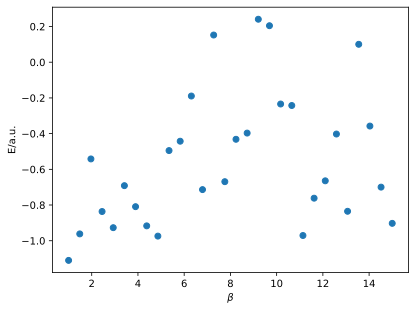

beta with minimal energy:1.0


In [8]:
trial_point = np.array([[-0.05317037, -0.07002718,  0.0897823],
                        [-0.00266115,  0.00061476, -0.04018687]])
# [0.1, 0.3, 0.2]])
mol = pyscf.gto.M(atom="H 0 0 0; H 0 0 0.75", basis="6-31g", spin=0)
mf = pyscf.scf.RHF(mol)
mf.kernel()
mol_SJ = molecule.Pade_sing_param(mf, elec_pos=trial_point, params=np.array([1.]))
E_list = []
N = 30
beta_list = np.linspace(1, 15, N)
i = 1
for beta in beta_list:
    print(f"scanning beta: {i}/{N}")
    E_mean = VMC_E(np.array([beta]), init_state=trial_point, sigma=0.05, ansatz=mol_SJ,
                   n_cut=5000, n_interval=50, n_sample=10000, E_only=True,
                   verbose=False)  # this function will adjust the parameters automatcially
    E_list.append(E_mean)
    i += 1

plt.scatter(beta_list, E_list)
plt.ylabel("E/a.u.")
plt.xlabel(r"$\beta$")
plt.show()
print(f"beta with minimal energy:{beta_list[np.argmin(E_list)]}")

The result $E(\beta)$ is extremely wriggled. It is possible that the the dependence of $E$ on beta is not that regular, but this wriggled shape of $E(\beta)$ is possibly largely due to the immense statistical weight in VMC, where not enouth samples are taken.

Several improvements can be made to my naive implementation:
- Calculate the local kinetic energy analytically. It is calculated numeically in my current implementation. We can define the ansatz object in the implementation to record the local information including D, transpose of inverse of D, E_L, v_D, etc. The accessing function may just return the value with a littile computation.
- Update the wave function and local energy after a single-electron move (e.g., [1]). In the current implementation everything is recalculated after perturbation.

Reference
[1] S. Fahy, X. W. Wang, and S. G. Louie, Variational Quantum Monte Carlo Nonlocal Pseudopotential Approach to Solids: Formulation and Application to Diamond, Graphite, and Silicon, Phys. Rev. B 42, 3503 (1990).

[2] P. J. Reynolds, D. M. Ceperley, B. J. Alder, and W. A. Lester, Fixed-Node Quantum Monte Carlo for Moleculesa, The Journal of Chemical Physics 77, 5593 (1982).


Before starting the DMC experiment, let's calculate the HF and FCI energy of H2 as a benchmark.


In [10]:
from pyscf import fci
print(f"HF energy of H2: {mf.e_tot} a.u.")
fci_h2 = fci.FCI(mf)
e_fci, fci_vector = fci_h2.kernel()
print(f"FCI energy of H2: {e_fci} a.u.")

HF energy of H2: -1.1265450345356904 a.u.
FCI energy of H2: -1.1516885475166099 a.u.


# DMC implementation
I implement a naive fixed-node DMC (with importance sampling) in QuntumMC.DMC. I will here use DMC to calculate the energy of H2 with the HF slater determinent as the trial wave function.


In [19]:
import pyscf
from QuantumMC.VMC.sample import VMC_E
from QuantumMC.ansatz import molecule
from QuantumMC.DMC.fixed_node import DMC_walk
import numpy as np

trial_point = np.array([[-0.05317037, -0.07002718,  0.0897823],
                        [-0.00266115,  0.00061476, -0.04018687]])

mol = pyscf.gto.M(atom="H 0 0 0; H 0 0 0.75", basis="6-31g", spin=0)
mf = pyscf.scf.RHF(mol)
mf.kernel()
mol_SJ = molecule.Pure_det(mf, elec_pos=trial_point, params=np.array([1]))
# print(mol_SJ.v_D(elec_pos=trial_point, params=np.array([])))
sample, E_mean, E_var, n = VMC_E(np.array([]), init_state=trial_point, sigma=0.1, ansatz=mol_SJ,
                                 n_cut=10000, n_interval=50, n_sample=200, E_only=False,
                                 verbose=True)
print(f"VMC E: {E_mean}")
# print(E_mean, E_var, n)
print()
states, E, var, n_f, E_log, n_log = DMC_walk(mol_SJ, sample, init_ET=E_mean, tau=0.01, n_step=100, verbose=True, log=True)


converged SCF energy = -1.12654503453569
start sampling
samples: 20/200
samples: 40/200
samples: 60/200
samples: 80/200
samples: 100/200
samples: 120/200
samples: 140/200
samples: 160/200
samples: 180/200
VMC E: -1.0330340519474497

start walking 200 walkers.
step 10: E_mean=-1.02963, n_walker=198, acc_rate=0.97487
step 20: E_mean=-1.03546, n_walker=199, acc_rate=0.98995
step 30: E_mean=-1.03622, n_walker=199, acc_rate=0.95980
step 40: E_mean=-1.03803, n_walker=199, acc_rate=0.97487
step 50: E_mean=-1.04055, n_walker=200, acc_rate=0.96500
step 60: E_mean=-1.04201, n_walker=202, acc_rate=0.99505
step 70: E_mean=-1.04842, n_walker=203, acc_rate=0.94554
step 80: E_mean=-1.04573, n_walker=202, acc_rate=0.97525
step 90: E_mean=-1.04688, n_walker=203, acc_rate=0.96059


In [20]:
print("DMC E:", E)
print("var", var)

DMC E: -1.0460303992511844
var 0.00411178000947238


Text(0.5, 0, 'walk step')

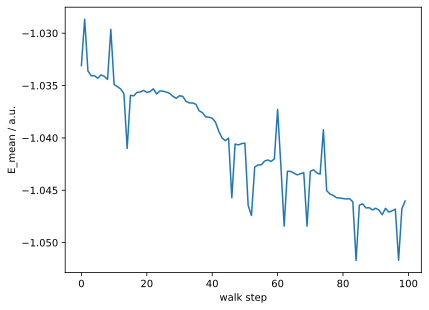

In [27]:
plt.plot(E_log)
plt.ylabel("E_mean / a.u.")
plt.xlabel("walk step")

We can see that the DMC energy is decreasing as the walk proceed, but the precision of the result is not satisfactory. Increasing the number of walkers, decreasing $\tau$, and increasing the number of steps will in theory improve the results.